<a href="https://colab.research.google.com/github/AmirAAZ818/LPCVC_2023/blob/main/LPCVC_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-info" role="alert">
  <h1><strong>LPCVC, On-device Disaster Scene Parsing Competition</strong></h1>
  <p>In this notebook, we delve into the fascinating world of disaster scene parsing using on-device processing. I had the incredible opportunity to participate in the LPCVC (Low Power Computer Vision Challenge) competition, which focused on this very task. The goal was to perform semantic segmentation on 512 x 512 images captured from a sky-earth perspective by a UAV, all in real-time using the Jetson Nano 2GB embedded on board.</p>
  <p>Through this competition, I gained invaluable insights into real-world applications of computer vision in disaster management scenarios. This notebook serves as a documentation of my journey, outlining the steps, code, and insights gathered along the way.</p>
  <p>For more information about the LPCVC competition, visit the <a href="https://lpcv.ai/2023LPCVC/introduction" target="_blank">official website</a>.</p>
</div>


# Importing Modules and Installing Libraries

The competition guidelines specified the use of PyTorch, which is the deep learning framework I used for this task. Additionally, I made use of Hugging Face's `transformers` module, a powerful library for working with pre-trained models in computer vision and NLP tasks.


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.8 MB/s eta 0:00:00


In [ ]:
# pytorch imports
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torch import nn

# transfomers imports
from transformers import AdamW
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

import os
import glob

import cv2
from PIL import Image
import albumentations as au


import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score

# Dataset Acquisition and Analysis

In this section, I'll cover the process of obtaining the LPCVC competition dataset, followed by an initial analysis to gain insights into the data.



## Obtaining the Dataset

We begin by downloading the LPCVC competition dataset. The dataset comprises 512 x 512 images captured from a sky-earth perspective by a UAV. The goal is to perform semantic segmentation on these images using the Jetson Nano 2GB embedded on board.(which won't be shown in this notebook)

In [ ]:
train_dataset_link = "https://drive.google.com/file/d/1De8WmoXnR0xanzrN2NLPjSzAvpEtiQYC/view?usp=drive_link"
val_dataset_link = "https://drive.google.com/file/d/1p0mVi3PxxCNPxT3GWzSsMtl_qjYxUr5q/view?usp=drive_link"
!gdown --id 1De8WmoXnR0xanzrN2NLPjSzAvpEtiQYC
!gdown --id 1p0mVi3PxxCNPxT3GWzSsMtl_qjYxUr5q

!unzip "/content/LPCVC_Train_Updated.zip"
!unzip "/content/LPCVC_Val.zip"

# Removing the zip files to keep the session space clean.
!rm /content/LPCVC_Train_Updated.zip
!rm /content/LPCVC_Val.zip

# Changing the name of a directory(don't mind this code)
!mv /content/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/GT_Updated /content/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/GT

In [ ]:
trainset_root = r"/content/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated"
valset_root = r"/content/LPCVC_Val/LPCVC_Val"

## Dataset Overview

The dataset for the LPCVC on-device disaster scene parsing competition consists of images captured from a UAV perspective during various disaster scenes. The goal is to segment and parse these images into different regions associated with semantic categories related to disasters.

### Dataset Details

- Total Number of Images: 1,720
- Training/Validation Set: 1,120 Images
- Testing Set: 600 Images (Reserved for Benchmarking Submissions)

All images in the dataset are resized to a standardized resolution of 512x512 pixels.

### Semantic Categories

The dataset is densely annotated with 14 distinct categories, each representing a specific aspect related to disaster scenes. Below is the list of categories along with their corresponding IDs:

| Class ID | Category                          |
|----------|-----------------------------------|
| 0        | Background                        |
| 1        | Avalanche                         |
| 2        | Building Undamaged                |
| 3        | Building Damaged                  |
| 4        | Cracks/Fissure/Subsidence         |
| 5        | Debris/Mud/Rock Flow              |
| 6        | Fire/Flare                        |
| 7        | Flood/Water/River/Sea             |
| 8        | Ice Jam Flow                      |
| 9        | Lava Flow                         |
| 10       | Person                            |
| 11       | Pyroclastic Flow                  |
| 12       | Road/Railway/Bridge               |
| 13       | Vehicle                           |



In [ ]:
# Assiging the list of images and gts to the corresponding vars
train_images = sorted(glob.glob(os.path.join(trainset_root, 'IMG', 'train', "*.png")))
train_gt = sorted(glob.glob(os.path.join(trainset_root, 'GT', 'train', "*.png")))
print(f"num of train samples are : {len(train_images)}")

val_images = sorted(glob.glob(os.path.join(valset_root, 'IMG', 'val', "*.png")))
val_gt = sorted(glob.glob(os.path.join(valset_root, 'GT', 'val', "*.png")))
print(f"num of validation samples are : {len(val_images)}")


num of train samples are : 1021
num of validation samples are : 100


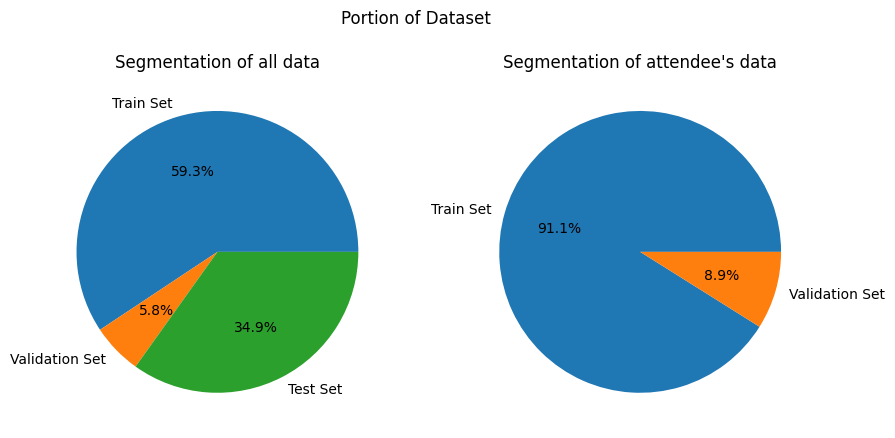

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(10, 5))

# Segmentation of all data in the competition
y = [len(train_images), len(val_images), 600]
lbls = ['Train Set', 'Validation Set', 'Test Set']
axis[0].pie(y, labels=lbls, autopct='%1.1f%%')
axis[0].set_title('Segmentation of all data')

# Data set available for attendee
y = [len(train_images), len(val_images)]
lbls = ['Train Set', 'Validation Set']
axis[1].pie(y, labels=lbls, autopct='%1.1f%%')
axis[1].set_title("Segmentation of attendee's data")

fig.suptitle("Portion of Dataset")
plt.show()

## Visualizing Sample Images

This section initiates a visual exploration of the dataset, presenting a curated selection of example images. The purpose is to provide an initial glimpse into the diverse disaster scenes observed from the UAV perspective, along with their detailed annotations. This endeavor sets the stage for a deeper understanding of the dataset's content and characteristics.

Additionally, there are two variables in this section:

- `num_img_show`: This integer variable determines the number of images displayed simultaneously. Adjust this based on your preferences.
- `train_set_show`: This boolean variable allows you to choose whether to view samples from the training set or the validation set.

Note: Feel free to customize these variables to tailor the viewing experience to your specific needs.


todo: make legend or custome color palette

In [ ]:
def make_title(ids, id2label):
  title = ''
  for id in ids:
    title += id2label[id]

  return title

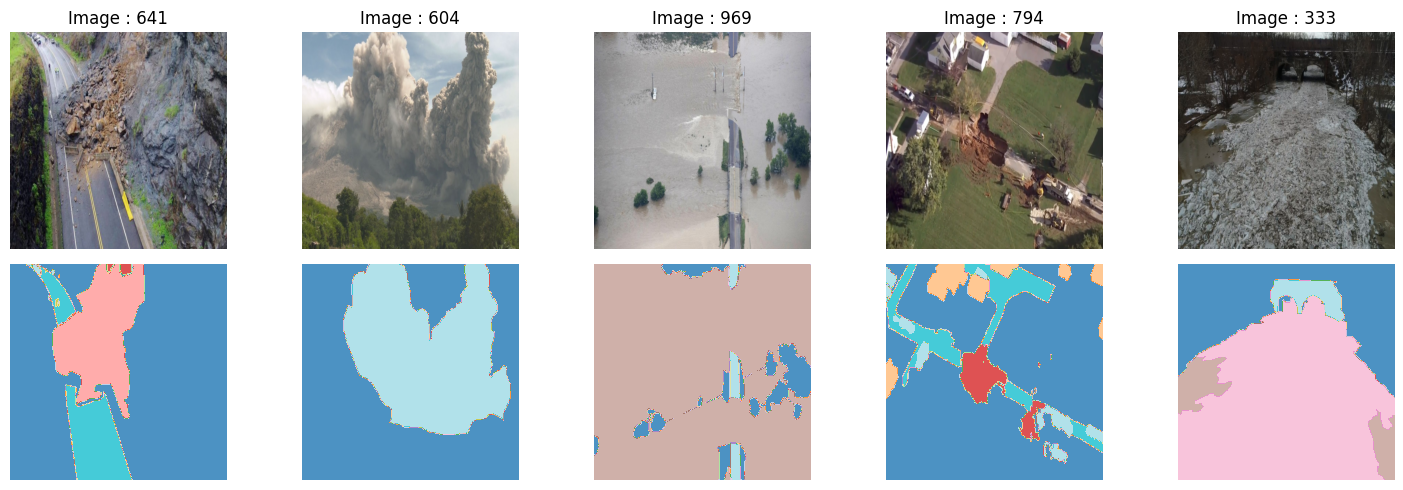

In [ ]:
import random
import matplotlib.patches as mpatches

# Settings
num_img_show : int = 5 # Feel free to change this value to see more or less samples from the dataset

train_set_show : bool = True  # If set to true, you will see "num_image_show" images of the training set

id2label = {0:"background ", 1:"avalanche ", 2:"building_undamaged ", 3:"building_damaged ",
            4:"cracks/fissure/subsidence ", 5:"debris/mud//rock flow ", 6:"fire/flare ", 7:"flood/water/river/sea ",
            8:"ice_jam_flow ", 9:"lava_flow ", 10:"person ", 11:"pyroclastic_flow ", 12:"road/railway/bridge ", 13:"vehicle "}

colormap = {0:"#1f77b4"} #tab20 colors (for making legend later)

# Get random indexes for showing some samples of the dataset
if train_set_show :
  idxs = random.sample(range(0, 1021), num_img_show)
  images = train_images
  gts = train_gt

else:
  idxs = random.sample(range(0,100), num_img_show)
  images = val_images
  gts = val_gt



# Showing images with their mask
fig, axes = plt.subplots(2, num_img_show, figsize=(15, 5))



for i in range(num_img_show):
  idx = idxs[i]

  # Opening image and its gt ...
  img = Image.open(images[idx])
  img_np = np.array(img)

  gt = Image.open(gts[idx]) # grayscale image
  gt_np = np.array(gt)[:, :, 0]  # to keep it gray scale :)

  ax_img = axes[0, i] # row , column
  ax_gt = axes[1, i]

  ax_img.imshow(img_np, cmap='gray')
  ax_gt.imshow(gt_np, alpha=0.8, cmap='tab20')

  # ids = np.unique(gt_np)
  # labels = make_title(ids, id2label)
  ax_img.set_title(f"Image : {idx}")

  ax_img.axis('off')
  ax_gt.axis('off')



plt.tight_layout()
plt.show()

## Class Distribution

we took a close look at how different categories are represented in our dataset. This is crucial for building effective models.

After careful examination, we noticed that four categories - "Avalanche," "Ice Jam Flow," "Lava Flow," and "Pyroclastic Flow" - have fewer examples compared to others. On the other hand, the rest of the categories are fairly evenly represented.

We also found that this pattern holds true for both the training and validation sets. This led us to believe that the test set should follow a similar distribution for a fair evaluation of the model's performance.

For the categories with fewer examples, we decided not to artificially increase the dataset size. Doing so might not significantly improve the model's performance because of the test set's distribution.


In [ ]:
# Preparing Data for countplot
tlabels = list()
vlabels = list()

for dir in train_gt:
  gt = Image.open(dir)
  gt = np.array(gt)[:, :, 0]
  lbls = np.unique(gt).tolist()
  tlabels += lbls


for dir in val_gt:
  gt = Image.open(dir)
  gt = np.array(gt)[:, :, 0]
  lbls = np.unique(gt).tolist()
  vlabels += lbls

df_train_labels = {'class':tlabels}
df_val_labels = {'class':vlabels}
df_val_labels['class'].append(9) # So the countplot would show label 9


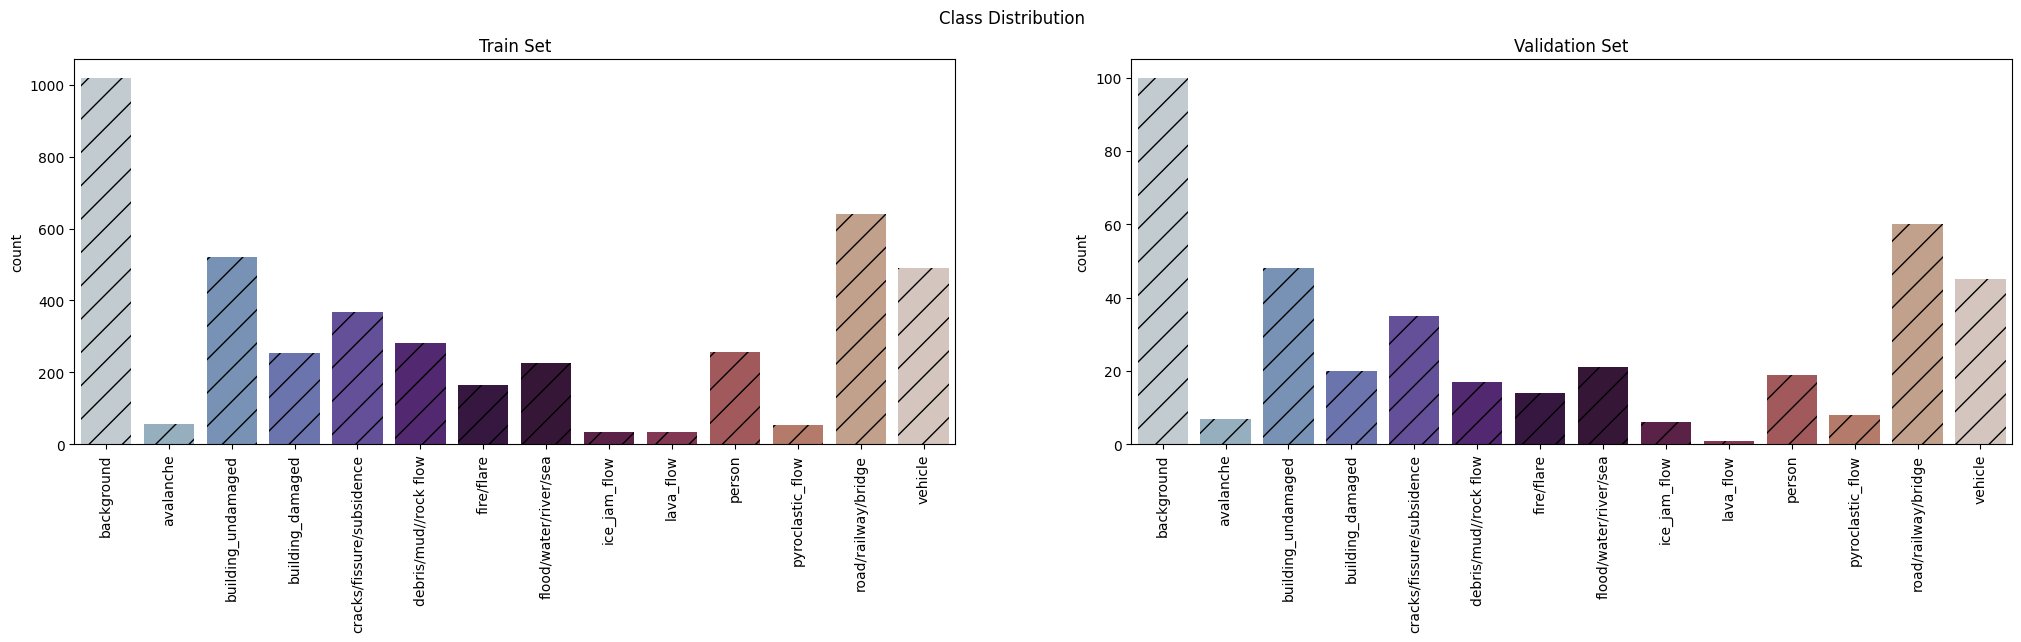

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(25, 5))

# Train set countplot
sns.countplot(x='class', data=df_train_labels, ax=axis[0], palette='twilight', hatch='/')
axis[0].set_xticklabels(["background", "avalanche", "building_undamaged", "building_damaged",
            "cracks/fissure/subsidence", "debris/mud//rock flow", "fire/flare", "flood/water/river/sea",
            "ice_jam_flow", "lava_flow", "person", "pyroclastic_flow", "road/railway/bridge", "vehicle"], rotation=90)
axis[0].set_title('Train Set')

# Validation set countplot
sns.countplot(x='class', data=df_val_labels, ax=axis[1], palette='twilight', hatch='/')
axis[1].set_xticklabels(["background", "avalanche", "building_undamaged", "building_damaged",
            "cracks/fissure/subsidence", "debris/mud//rock flow", "fire/flare", "flood/water/river/sea",
            "ice_jam_flow", "lava_flow", "person", "pyroclastic_flow", "road/railway/bridge", "vehicle"], rotation=90)
axis[1].set_title('Validation Set')


plt.suptitle("Class Distribution")
plt.show()

## Custom Dataset Class Implementation

In [ ]:
class ImageSegmentationDataset(Dataset):
    def __init__(self, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        # pick train set or val set
        if self.train:
          self.img_dir = os.path.join(trainset_root, 'IMG', 'train')
          self.ann_dir = os.path.join(trainset_root, 'GT', 'train')
        else:
          self.img_dir = os.path.join(valset_root, 'IMG', 'val')
          self.ann_dir = os.path.join(valset_root, 'GT', 'val')

        # read images' names
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations' names
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # pre processing the image(I don't know why, it just turned out to give better results)

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)

        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
train_dataset = ImageSegmentationDataset(feature_extractor=feature_extractor, train=True)
valid_dataset = ImageSegmentationDataset(feature_extractor=feature_extractor, train=False)

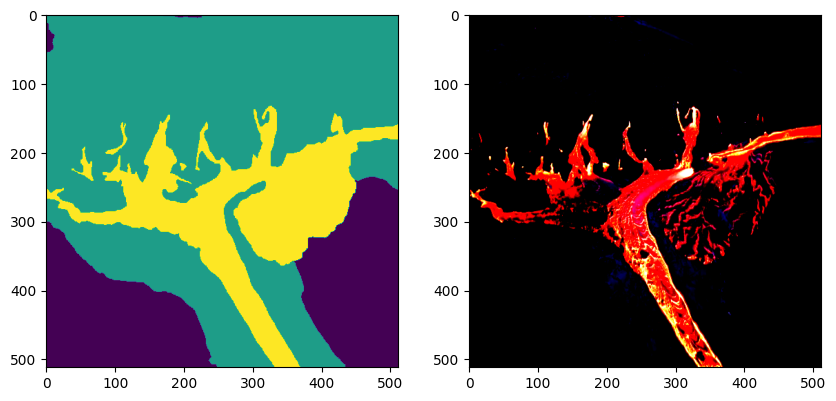

In [ ]:
# making sure it is working correctly
train_instance = train_dataset[519]
fig, axis = plt.subplots(1, 2, figsize=(10,5))

img = train_instance["pixel_values"].permute(1,2,0).numpy()
mask = train_instance["labels"].numpy()

axis[0].imshow(mask)
axis[1].imshow(img)

plt.show()

# Model Training and Fine-tuning

In this section, I started the training process, focusing on fine-tuning the Segformer model.
The Segformer model is a powerful tool for semantic segmentation tasks. I fine-tuned various versions, ranging from b2 to b5, in order to later make a comparison between them and find out which one is the best.

🤗Transformers: [official documentation](https://huggingface.co/docs/transformers/model_doc/segformer).


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1)

In [ ]:
id2label = {0:"background", 1:"avalanche", 2:"building_undamaged", 3:"building_damaged",
            4:"cracks/fissure/subsidence", 5:"debris/mud//rock flow", 6:"fire/flare", 7:"flood/water/river/sea",
            8:"ice_jam_flow", 9:"lava_flow", 10:"person", 11:"pyroclastic_flow", 12:"road/railway/bridge", 13:"vehicle"}

label2id = {v: k for k, v in id2label.items()}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Early Stopping Class

In [ ]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.status = "First epoch and init of variables"
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

## Model: MIT-B2

### Configuration

In [ ]:
# Loading model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b2",
                                                         num_labels=len(id2label),
                                                         id2label=id2label,
                                                         label2id=label2id,
                                                         reshape_last_stage=True
)

In [ ]:
# Training Args
optimizer = AdamW(model.parameters(), lr=0.00006)

In [ ]:
# History                             # WARNING : Do not rerun this cell if you are not sure
from torchmetrics import Dice
dice_metric = Dice(num_classes=14, ignore_index=0)
early_stop = EarlyStopping(min_delta=5e-2, patience=2)
b2_metric_history = {'dice':list(), 'acc':list()}
b2_loss_history = {'val_loss': list(), 'train_loss': list()}

### Training Loop

In [ ]:
model.to(device)
epochs : int = 10 # you can change this
stop = False
# Training Loop
for epoch in range(epochs):
  if stop:
    print(f"_______________Training stoped at {epoch + 1}_______________")
    break

  print("Epoch:", epoch + 1)

  train_pb = tqdm(train_dataloader)
  train_loss = 0

  model.train()
  for idx, batch in enumerate(train_pb):

    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    outputs = model(pixel_values=pixel_values, labels=labels)

    # Calculating loss
    loss = outputs.loss
    train_loss = loss.item()

    # Learning Step
    loss.backward()
    optimizer.step()

    # Progress bar info
    train_pb.set_postfix({'Batch': idx + 1, 'Train_Loss': loss.item()})

  #loss history update
  b2_loss_history['train_loss'].append(train_loss)

  # Evaluation
  val_loss = 0
  acc_list = list()
  dice_metric.reset()

  model.eval()
  with torch.no_grad():

    valid_pb = tqdm(valid_dataloader)

    for idx, batch in enumerate(valid_pb):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      output = model(pixel_values=pixel_values, labels=labels)
      upsampled_logits = nn.functional.interpolate(output.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False) # upsampled_logits.shape : (1, 14, 512, 512)
      predicted = upsampled_logits.argmax(dim=1) # (1, 14, 512, 512) -> (1, 512, 512)

      pred_labels = predicted.detach().cpu().numpy()
      true_labels = labels.detach().cpu().numpy()

      val_loss = output.loss.item()

      pred_flat_pt = torch.tensor(pred_labels.flatten())
      gt_flat_pt = torch.tensor(true_labels.flatten())

      dice = dice_metric(pred_flat_pt, gt_flat_pt) # computing dice for a batch




      mask = (labels != 0) # we don't include the background class in the accuracy calculation
      pred_labels = predicted[mask].detach().cpu().numpy()
      true_labels = labels[mask].detach().cpu().numpy()
      accuracy = accuracy_score(pred_labels, true_labels)
      acc_list.append(accuracy)

      # pbar update
      valid_pb.set_postfix({'Batch': idx + 1, 'val_Loss': val_loss, 'Dice':dice.item(), 'Accuracy': accuracy})



    # history update
    b2_loss_history['val_loss'].append(val_loss)

    dice_ceo = dice_metric.compute() # computing the dice of the batches (for this epoch)
    b2_metric_history['dice'].append(dice_ceo.item())

    b2_metric_history['acc'].append(sum(acc_list)/len(acc_list))

    # early stoping
    if early_stop(model, val_loss):
      stop = True

    # Seeing the status of the early stopping
    print(early_stop.status)

Epoch: 1


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

First epoch and init of variables
Epoch: 2


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Improvement found, counter reset to 0
Epoch: 3


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Improvement found, counter reset to 0
Epoch: 4


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

No improvement in the last 1 epochs
Epoch: 5


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Improvement found, counter reset to 0
Epoch: 6


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

No improvement in the last 1 epochs
Epoch: 7


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping triggered after 2 epochs.
_______________Training stoped at 8_______________


### Evaluation
Plotting the Loss and Metrics in order to get a better understanding of the model's performance.

**Making Losses a Little Smoother**

In [ ]:
window_size = 3

def centered_moving_average(data, window_size):
    half_window = window_size // 2
    smoothed_data = []
    for i in range(half_window, len(data) - half_window):
        smoothed_value = np.mean(data[i - half_window : i + half_window + 1])
        smoothed_data.append(smoothed_value)
    return smoothed_data

smoothed_train_losses = centered_moving_average(b2_loss_history['train_loss'], window_size)
smoothed_val_losses = centered_moving_average(b2_loss_history['val_loss'], window_size)

**Plotting Losses and Metrics**

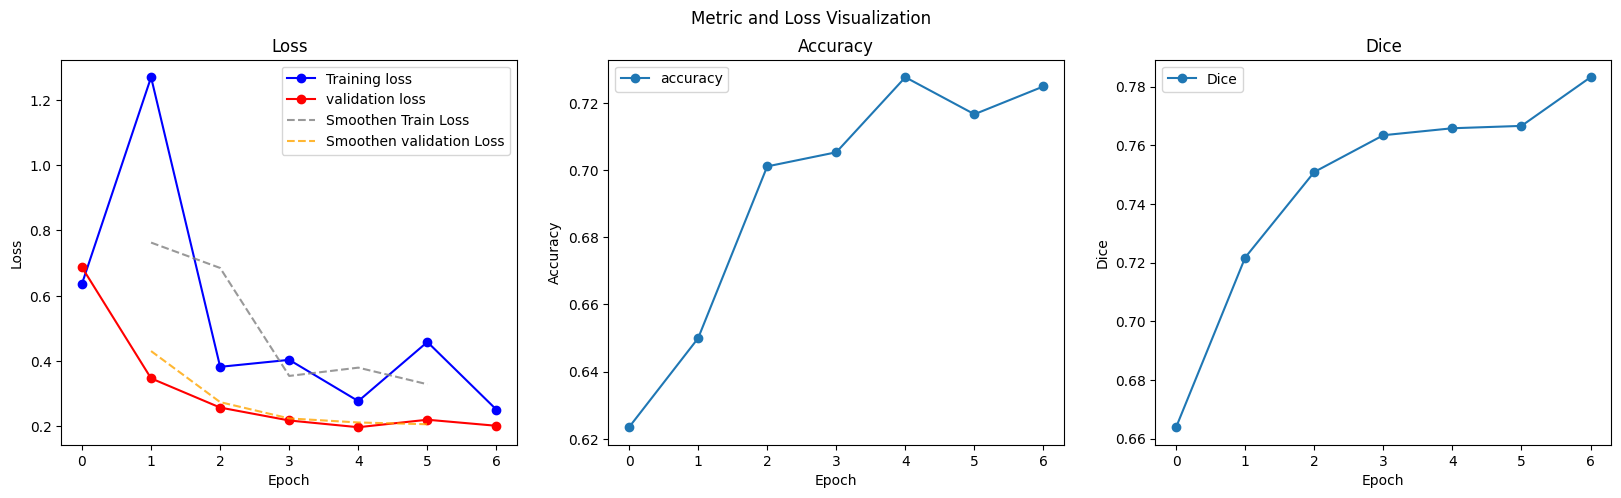

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_epochs = len(b2_loss_history['val_loss'])
# loss plot
axes[0].plot(range(plot_epochs), b2_loss_history['train_loss'],color='blue', label='Training loss', marker='o')
axes[0].plot(range(plot_epochs), b2_loss_history['val_loss'],color='red', label='validation loss', marker='o')
axes[0].plot(list(range(plot_epochs))[1:-1], smoothed_train_losses, linestyle='--', color='gray', alpha=0.8, label='Smoothen Train Loss')
axes[0].plot(list(range(plot_epochs))[1:-1], smoothed_val_losses, linestyle='--', color='orange', alpha=0.8, label='Smoothen validation Loss')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')

# acc plot
axes[1].plot(range(plot_epochs), b2_metric_history['acc'], label='accuracy', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')

# dice plot
axes[2].plot(range(plot_epochs), b2_metric_history['dice'], label='Dice', marker='o')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Dice')
axes[2].set_title('Dice')

fig.suptitle("Metric and Loss Visualization")

axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

### Saving History and Model
Saving history in json format in the session's strogae.
<br>Saving the best model in the session's storage.

In [ ]:
import json

!mkdir History
!mkdir History/B2

path = "History/B2/metric.json"

with open(path, 'w') as file:
  json.dump(b2_metric_history, file)

path = "History/B2/loss.json"

with open(path, 'w') as file:
  json.dump(b2_loss_history, file)

model_path = "History/B2/segformer_b2_finetuned.pkl"
torch.save(model.state_dict(), model_path)

print('Results Saved ...')

Results Saved ...


fatal: not a git repository (or any of the parent directories): .git
